In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob

from keras.models import load_model

In [3]:
#constants
IMG_W, IMG_H, IMG_C = (160, 160, 3)

In [4]:
DATA_PATH = '../data/105_classes_pins_dataset/'
dir_names = os.listdir(DATA_PATH)
person_names = [dir_name.split('_')[-1].title() for dir_name in dir_names]
number_of_persons = len(person_names)

print(f'Total number of persons: {number_of_persons}')
print(f'{person_names}')


Total number of persons: 105
['Adriana Lima', 'Alex Lawther', 'Alexandra Daddario', 'Alvaro Morte', 'Alycia Dabnem Carey', 'Amanda Crew', 'Amber Heard', 'Andy Samberg', 'Anne Hathaway', 'Anthony Mackie', 'Avril Lavigne', 'Barack Obama', 'Barbara Palvin', 'Ben Affleck', 'Bill Gates', 'Bobby Morley', 'Brenton Thwaites', 'Brian J. Smith', 'Brie Larson', 'Camila Mendes', 'Chris Evans', 'Chris Hemsworth', 'Chris Pratt', 'Christian Bale', 'Cristiano Ronaldo', 'Danielle Panabaker', 'Dominic Purcell', 'Dwayne Johnson', 'Eliza Taylor', 'Elizabeth Lail', 'Elizabeth Olsen', 'Ellen Page', 'Elon Musk', 'Emilia Clarke', 'Emma Stone', 'Emma Watson', 'Gal Gadot', 'Grant Gustin', 'Gwyneth Paltrow', 'Henry Cavil', 'Hugh Jackman', 'Inbar Lavi', 'Irina Shayk', 'Jake Mcdorman', 'Jason Momoa', 'Jeff Bezos', 'Jennifer Lawrence', 'Jeremy Renner', 'Jessica Barden', 'Jimmy Fallon', 'Johnny Depp', 'Josh Radnor', 'Katharine Mcphee', 'Katherine Langford', 'Keanu Reeves', 'Kiernen Shipka', 'Krysten Ritter', 'Leonar

In [5]:
DATA_PATH + dir_names[0]

'../data/105_classes_pins_dataset/pins_Adriana Lima'

In [6]:
n_images_per_person = [len(os.listdir(DATA_PATH + name)) for name in dir_names]
n_images = sum(n_images_per_person)

print(f'Total number of images: {n_images}')

Total number of images: 17534


In [2]:
import cv2 
import numpy as np
import mtcnn
from model import InceptionResNetV2
from training import normalize,l2_normalizer
from scipy.spatial.distance import cosine
from keras.models import load_model
import pickle

In [3]:
confidence_t=0.99
recognition_t=0.5
required_size = (160,160)

In [4]:
def get_face(img, box):
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = img[y1:y2, x1:x2]
    return face, (x1, y1), (x2, y2)

def get_encode(face_encoder, face, size):
    face = normalize(face)
    face = cv2.resize(face, size)
    encode = face_encoder.predict(np.expand_dims(face, axis=0))[0]
    return encode


def load_pickle(path):
    with open(path, 'rb') as f:
        encoding_dict = pickle.load(f)
    return encoding_dict

def detect(img ,detector,encoder,encoding_dict):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(img_rgb)
    names = []
    for res in results:
        if res['confidence'] < confidence_t:
            continue
        face, pt_1, pt_2 = get_face(img_rgb, res['box'])
        encode = get_encode(encoder, face, required_size)
        encode = l2_normalizer.transform(encode.reshape(1, -1))[0]
        name = 'unknown'

        distance = float("inf")
        for db_name, db_encode in encoding_dict.items():
            dist = cosine(db_encode, encode)
            if dist < recognition_t and dist < distance:
                name = db_name
                distance = dist
        names.append(name)
        if name == 'unknown':
            cv2.rectangle(img, pt_1, pt_2, (0, 0, 255), 2)
            cv2.putText(img, name, pt_1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        else:
            cv2.rectangle(img, pt_1, pt_2, (0, 255, 0), 2)
            cv2.putText(img, name, (pt_1[0], pt_1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (0, 200, 200), 2)
    return img, names, distance

def verify(img1,img2,detector,encoder):
        img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        results1 = detector.detect_faces(img1_rgb)
        results2 = detector.detect_faces(img2_rgb)
        
        for res1 in results1:
            for res2 in results2:
                if res1['confidence'] < confidence_t or res2['confidence'] < confidence_t:
                    continue
                face1, pt_11, pt_12 = get_face(img1_rgb, res1['box'])
                face2, pt_21, pt_22 = get_face(img2_rgb, res2['box'])
                encode1 = get_encode(encoder,face1, required_size)
                encode2 = get_encode(encoder,face2, required_size)
                encode1 = l2_normalizer.transform(encode1.reshape(1, -1))[0]
                encode2 = l2_normalizer.transform(encode2.reshape(1, -1))[0]
                distance = cosine(encode1, encode2)
                name = 'unknown'
                if distance < recognition_t:
                    name = 'verified'
                    cv2.rectangle(img1, pt_11, pt_12, (0, 255, 0), 2)
                    cv2.putText(img1, name , (pt_11[0], pt_11[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 200, 200), 2)
                    cv2.rectangle(img2, pt_21, pt_22, (0, 255, 0), 2)
                    cv2.putText(img2, name , (pt_21[0], pt_21[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 200, 200), 2)
                # else:
                #     name = 'unverified'
                #     cv2.rectangle(img1, pt_11, pt_12, (0, 0, 255), 2)
                #     cv2.putText(img1, name , (pt_11[0], pt_11[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 200, 200), 2)
                #     cv2.rectangle(img2, pt_21, pt_22, (0, 0, 255), 2)
                #     cv2.putText(img2, name , (pt_21[0], pt_21[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 200, 200), 2)

        return img1, img2

In [5]:
required_shape = (160,160)
face_encoder = InceptionResNetV2()
path_m = "../model/keras-facenet/weights/facenet_keras_weights.h5"
face_encoder.load_weights(path_m)
encodings_path = '../model/lfw.pkl'
face_detector = mtcnn.MTCNN()
encoding_dict = load_pickle(encodings_path)

In [7]:
encoding_dict.keys()

dict_keys(['Ciro_Gomes', 'Chung_Mong-hun', 'Aaron_Peirsol', 'Aaron_Sorkin', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdullah', 'Abdullah_Gul', 'Abdullah_al-Attiyah', 'Abdullatif_Sener', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adrian_McPherson', 'Adrian_Nastase', 'Adrien_Brody', 'Ahmad_Masood', 'Ahmed_Chalabi', 'Ahmet_Necdet_Sezer', 'Ai_Sugiyama', 'Aicha_El_Ouafi', 'Aitor_Gonzalez', 'Akbar_Hashemi_Rafsanjani', 'Akhmed_Zakayev', 'Al_Davis', 'Al_Gore', 'Al_Pacino', 'Al_Sharpton', 'Alan_Ball', 'Alan_Greenspan', 'Alan_Mulally', 'Alastair_Campbell', 'Albert_Costa', 'Alberto_Fujimori', 'Alberto_Ruiz_Gallardon', 'Albrecht_Mentz', 'Aldo_Paredes', 'Alec_Baldwin', 'Alejandro_Atchugarry', 'Alejandro_Avila', 'Alejandro_Toledo', 'Aleksander_Kwasniewski', 'Alex_Barros', 'Alex_Penelas', 'Alex_Sink', 'Alexander_Downer', 'Alexander_Losyukov', 'Alexander_Rumyantsev', 'Alexandra_Stevenson', 'Alexand

1/1 [==============================] - 0s 33ms/step


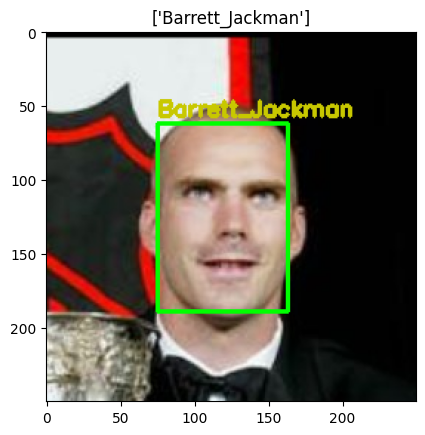

In [15]:
test_image = '../data/lfw/Barrett_Jackman/Barrett_Jackman_0002.jpg'
img = cv2.imread(test_image)
img,names, distance = detect(img, face_detector, face_encoder, encoding_dict)
plt.title(f'{names}')
plt.imshow(img[:,:,::-1])

In [16]:
VAL_PATH = '../data/lfw/'
val_dir_names = os.listdir(VAL_PATH)

print(f'Total number of persons: {len(val_dir_names)}')
print(f'{val_dir_names}')

Total number of persons: 5749
['Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abbas_Kiarostami', 'Abba_Eban', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_al-Attiyah', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullatif_Sener', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adelina_Avila', 'Adel_Al-Jubeir', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adriana_Lima', 'Adriana_Perez_Navarro', 'Adrianna_Zuzic', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase', 'Adrien_Brody', 'Afton_Smith', 'Agbani_Darego

In [17]:
all_persons = encoding_dict.keys()
# select 100 persons randomly
import random
random.seed(42)
selected_persons = random.sample(all_persons, 100)
print(f'Total number of persons: {len(selected_persons)}')
print(f'{selected_persons}')

Total number of persons: 100
['Queen_Latifah', 'Carlos_Menem', 'Alexander_Rumyantsev', 'Steven_Seagal', 'Greg_Rusedski', 'GL_Peiris', 'Ethan_Hawke', 'Christine_Baumgartner', 'Stephen_Friedman', 'Bruce_Springsteen', 'Robert_Horan', 'Steve_Waugh', 'Michelle_Kwan', 'Bo_Pelini', 'Oleksandr_Moroz', 'Kamal_Kharrazi', 'Alvaro_Silva_Calderon', 'Allen_Iverson', 'Bono', 'Eric_Robert_Rudolph', 'Filippo_Inzaghi', 'Marissa_Jaret_Winokur', 'Patrice_Chereau', 'Ali_Abbas', 'Mohamed_Benaissa', 'Eddy_Merckx', 'Sebastien_Grosjean', 'Reese_Witherspoon', 'Saeb_Erekat', 'Justin_Leonard', 'Erika_Harold', 'Lana_Clarkson', 'Norodom_Sihanouk', 'Guillaume_Soro', 'Xanana_Gusmao', 'Adam_Scott', 'Thomas_OBrien', 'William_Martin', 'Damon_van_Dam', 'Ruth_Dreifuss', 'Karen_Mok', 'Jay_Leno', 'Cristina_Fernandez', 'Emma_Thompson', 'Tim_Floyd', 'Jason_Alexander', 'Bobby_Robson', 'John_Howard', 'Brendan_Hansen', 'Jesse_Harris', 'Jean-Marc_de_La_Sabliere', 'Patrick_Leahy', 'Gianna_Angelopoulos-Daskalaki', 'Win_Aung', 'Ange

C:\Users\Dell\AppData\Local\Temp\ipykernel_41792\3738124605.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_persons = random.sample(all_persons, 100)


In [20]:
correct = 0
total = 0
true_names  = []
pred_names = []
p=1

for person in all_persons:
    print(f'Testing for {person} ## {p}/{len(all_persons)}')
    p+=1

    IMG_PATHS = os.listdir(os.path.join(VAL_PATH,person))
    img_path = os.path.join(VAL_PATH,person,IMG_PATHS[-1])

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_detector.detect_faces(img_rgb)
    names =[]
    for res in results:
        if res['confidence'] < confidence_t:
            continue

        x1, y1, width, height = res['box']
        x1, y1 = abs(x1) , abs(y1)
        x2, y2 = x1+width , y1+height
        face = img_rgb[y1:y2 , x1:x2]

        face = normalize(face)
        face = cv2.resize(face, required_shape)
        face_d = np.expand_dims(face, axis=0)
        encode = face_encoder.predict(face_d)[0]
        encode = l2_normalizer.transform(encode.reshape(1, -1))[0]

        name = 'unknown'
        distance = float("inf")

        for db_name, db_encode in encoding_dict.items():
            dist = cosine(db_encode, encode)
            if dist < recognition_t and dist < distance:
                name = db_name
                distance = dist
        names.append(name)

    if person in names:
        correct+=1
    total+=1

Testing for Ciro_Gomes ## 1/1680
1/1 [==============================] - 0s 48ms/step
Testing for Chung_Mong-hun ## 2/1680
1/1 [==============================] - 0s 32ms/step
Testing for Aaron_Peirsol ## 3/1680
1/1 [==============================] - 0s 43ms/step
Testing for Aaron_Sorkin ## 4/1680
1/1 [==============================] - 0s 32ms/step
Testing for Abdel_Nasser_Assidi ## 5/1680
1/1 [==============================] - 0s 49ms/step
Testing for Abdoulaye_Wade ## 6/1680
1/1 [==============================] - 0s 33ms/step
Testing for Abdullah ## 7/1680
1/1 [==============================] - 0s 43ms/step
Testing for Abdullah_Gul ## 8/1680
1/1 [==============================] - 0s 34ms/step
Testing for Abdullah_al-Attiyah ## 9/1680
1/1 [==============================] - 0s 48ms/step
Testing for Abdullatif_Sener ## 10/1680
1/1 [==============================] - 0s 50ms/step
Testing for Abel_Pacheco ## 11/1680
1/1 [==============================] - 0s 32ms/step
Testing for Abid_Hamid_M

In [24]:
print(f'Accuracy: {correct/total*100}%')

Accuracy: 99.46428571428572%
